# TASK 1: Defect Analysis

In [1]:
import subprocess
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
KEYWORDS = ["fix", "bug", "error", "issue", "hotfix", "resolve", "repair"]

- Obtention of commits since a given date (2023-01-01)

In [3]:
def get_git_commits_since(date="2023-01-01"):
    """
    Gets git commits since a given date using git log.
    """
    git_command = [
        "git", "log",
        f'--since={date}',
        "--pretty=format:%H|%ad|%s",
        "--date=short",
        "--name-only"
    ]
    result = subprocess.run(git_command, capture_output=True, text=True, encoding="utf-8", check=True)
    return result.stdout.split("\n") #we split the result in lines to process it more easily

- Creation of a commit dictionary (from unstructured raw git output to structured data)

In [4]:
def parse_commits(raw_lines):
    """
    Convert the raw lines returned by get_commits_since()
    into a clean list of commit dictionaries.
    Each commit contains: hash, date, message, and the files touched.
    """
    commits = []
    current = {}

    for line in raw_lines:
        if "|" in line: # a header line contains hash | date | message
            if current:
                commits.append(current)
            hash_, date, msg = line.split("|", 2)
            current = {"hash": hash_, "date": date, "msg": msg, "files": []}
        elif line.strip() == "":
            # empty line means a separator in git log output
            continue
        else:
            # file modified in this commit
            if "files" in current:
                current["files"].append(line.strip())

    if current:
        commits.append(current)

    return commits

- Detection of defect commits

In [5]:
def is_defect_commit(message):
    """
    If the commit message contains any keyword that is considered as defect, it outputs True.
    """
    msg = message.lower()
    return any(k in msg for k in KEYWORDS)

- Computation of defects per month, defects per file and defects per month for a file

In [6]:
def defects_per_month(commits):
    """
    Counts how many defect commits happened in each month, and returns a dict of the form: { 'YYYY-MM' : number_of_defects }
    """
    counter = defaultdict(int)
    for c in commits:
        # only count commits whose message suggests a defect fix
        if is_defect_commit(c["msg"]):
            month = c["date"][:7] # extracting YYYY-MM
            counter[month] += 1
    return counter


def defects_per_file(commits):
    """
    Counts how many times a file appeared in a defect commit. Returns a dict: { 'path/to/file.py' : number_of_defects }
    """
    file_counts = defaultdict(int)
    for c in commits:
        if is_defect_commit(c["msg"]):
            #every modified file in this commit is counted
            for f in c["files"]:
                file_counts[f] += 1
    return file_counts


def defects_per_month_for_file(commits, target_file):
    """
    Counts defect commits for a specific file, group by month. Returns a dict: { 'YYYY-MM' : number_of_defects_for_that_file }
    """
    counter = defaultdict(int)
    for c in commits:
        # only count defect commits that touched this specific file
        if is_defect_commit(c["msg"]) and target_file in c["files"]:
            month = c["date"][:7]
            counter[month] += 1
    return counter


In [7]:
def build_month_series(commits, defects_by_month):
    """
    Creates a month-by-month series based on all commit dates,
    filling missing months with 0 defects. 
    """
    all_months = sorted({commit["date"][:7] for commit in commits}) # we extract all months that appear in the commit history

    full_series = {month: defects_by_month.get(month, 0) for month in all_months} # we build a complete series, using 0 when a month has no defects. This is useful for ploting all months.
    return full_series

- Plotting utils

In [8]:
def plot_bar_chart(data, title, ylabel):

    months = sorted(data.keys()) # we sort keys to ensure the bars appear in chronological order
    values = [data[m] for m in months]

    plt.rcParams["figure.figsize"] = (10, 5) 
    plt.rcParams["figure.dpi"] = 120
    plt.figure()
    plt.bar(months, values)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

- Run Task 1 Analysis

In [9]:
#Obtaining commits sice 2023-01-01
raw = get_git_commits_since()
commits = parse_commits(raw)
len(commits)

8817

Defects per month: {'2023-01': 85, '2023-02': 89, '2023-03': 112, '2023-04': 81, '2023-05': 109, '2023-06': 99, '2023-07': 77, '2023-08': 85, '2023-09': 78, '2023-10': 108, '2023-11': 82, '2023-12': 93, '2024-01': 73, '2024-02': 68, '2024-03': 88, '2024-04': 119, '2024-05': 84, '2024-06': 73, '2024-07': 87, '2024-08': 81, '2024-09': 88, '2024-10': 113, '2024-11': 68, '2024-12': 63, '2025-01': 90, '2025-02': 91, '2025-03': 121, '2025-04': 138, '2025-05': 100, '2025-06': 134, '2025-07': 146, '2025-08': 146, '2025-09': 82, '2025-10': 0}


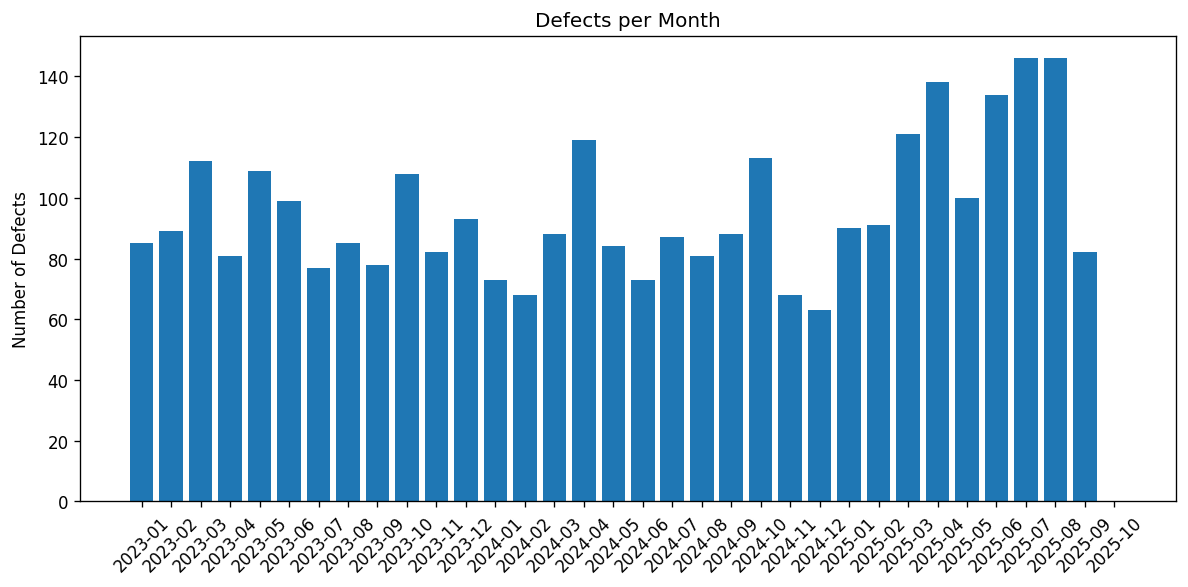

In [10]:
#Total number of defects per month
dpm = defects_per_month(commits)
dpm_full = build_month_series(commits, dpm)
print("Defects per month:", dpm_full)
plot_bar_chart(dpm_full, "Defects per Month", "Number of Defects")

In [11]:
#Top 2 defective files
df = defects_per_file(commits)
top2 = sorted(df.items(), key=lambda x: x[1], reverse=True)[:2]
top2

[('src/transformers/modeling_utils.py', 182),
 ('src/transformers/trainer.py', 176)]


File: src/transformers/modeling_utils.py (total defects: 182)
Defects per month for this file: defaultdict(<class 'int'>, {'2025-09': 5, '2025-08': 7, '2025-07': 14, '2025-06': 6, '2025-05': 5, '2025-04': 16, '2025-03': 19, '2025-02': 5, '2025-01': 3, '2024-12': 1, '2024-11': 5, '2024-10': 6, '2024-09': 4, '2024-08': 3, '2024-07': 5, '2024-05': 5, '2024-04': 6, '2024-03': 4, '2024-02': 5, '2024-01': 7, '2023-12': 6, '2023-11': 5, '2023-10': 6, '2023-09': 7, '2023-08': 8, '2023-07': 2, '2023-06': 3, '2023-05': 4, '2023-04': 3, '2023-03': 4, '2023-02': 2, '2023-01': 1})


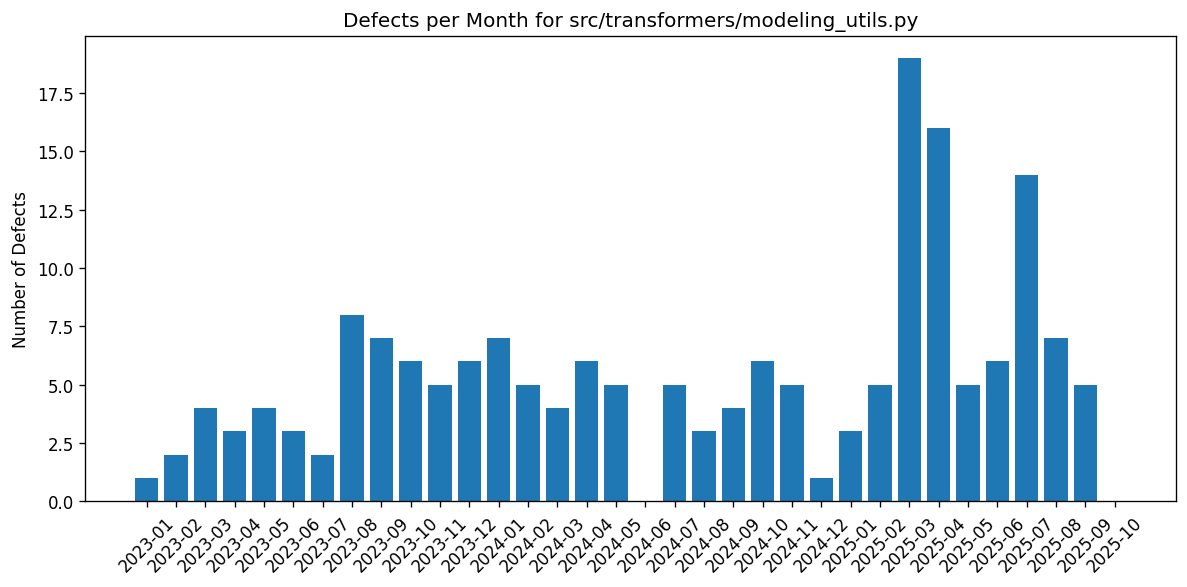


File: src/transformers/trainer.py (total defects: 176)
Defects per month for this file: defaultdict(<class 'int'>, {'2025-09': 3, '2025-08': 5, '2025-07': 6, '2025-06': 7, '2025-05': 5, '2025-04': 8, '2025-03': 5, '2025-02': 7, '2025-01': 4, '2024-12': 6, '2024-11': 4, '2024-10': 9, '2024-09': 3, '2024-07': 3, '2024-06': 3, '2024-05': 1, '2024-04': 3, '2024-03': 13, '2024-02': 4, '2024-01': 6, '2023-12': 5, '2023-11': 3, '2023-10': 1, '2023-09': 7, '2023-08': 4, '2023-07': 11, '2023-06': 15, '2023-05': 8, '2023-04': 4, '2023-03': 5, '2023-02': 4, '2023-01': 4})


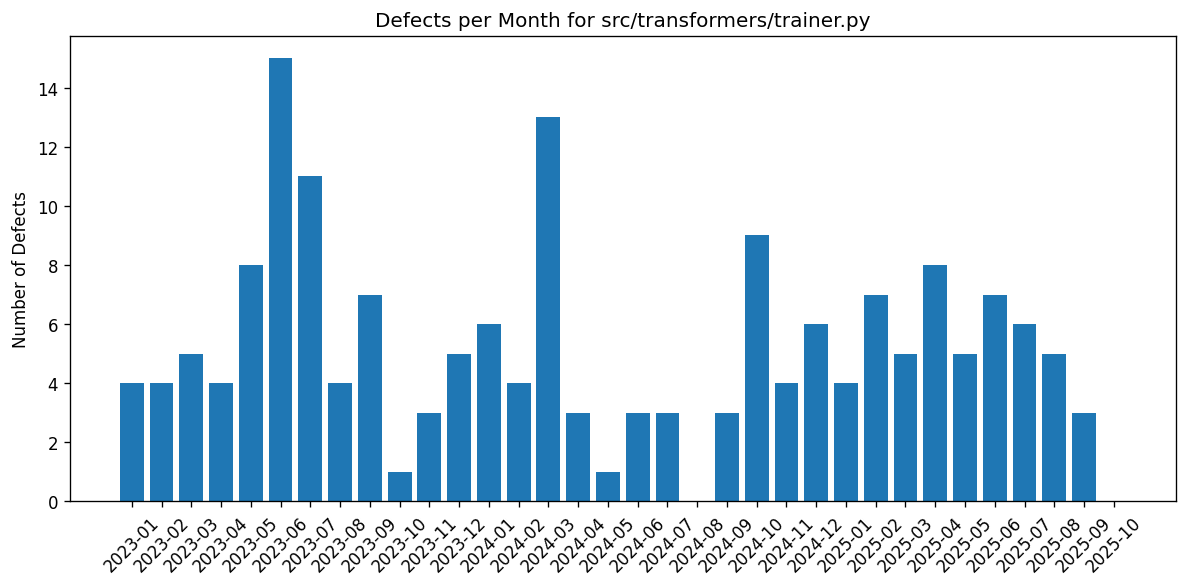

In [12]:
#Defects per month for each of the most defective files
for f, count in top2:
    print(f"\nFile: {f} (total defects: {count})")
    dpf = defects_per_month_for_file(commits, f)
    print("Defects per month for this file:", dpf)
    full_counts = build_month_series(commits, dpf)
    plot_bar_chart(full_counts, f"Defects per Month for {f}", "Number of Defects")

# TASK 3: Coupling Analysis

In [13]:
from collections import defaultdict
import itertools
import os
import matplotlib.pyplot as plt

- Computation of logical coupling for all Python file pairs

In [15]:
def is_python_file(path):
    return path.endswith(".py") # check to keep only Python source files.

def compute_logical_coupling(commits):
    coupling_counts = defaultdict(int)

    for commit in commits:
        python_files = [f for f in commit["files"] if is_python_file(f)] # we keep only Python files for this commit

        
        unique_files = sorted(set(python_files)) # we use a set to avoid counting the same file twice in one commit

        # For each unordered pair of files, we increase the coupling count
        for file_a, file_b in itertools.combinations(unique_files, 2):
            pair = (file_a, file_b)
            coupling_counts[pair] += 1

    return coupling_counts

- Plot of the top 10 coupled pairs 

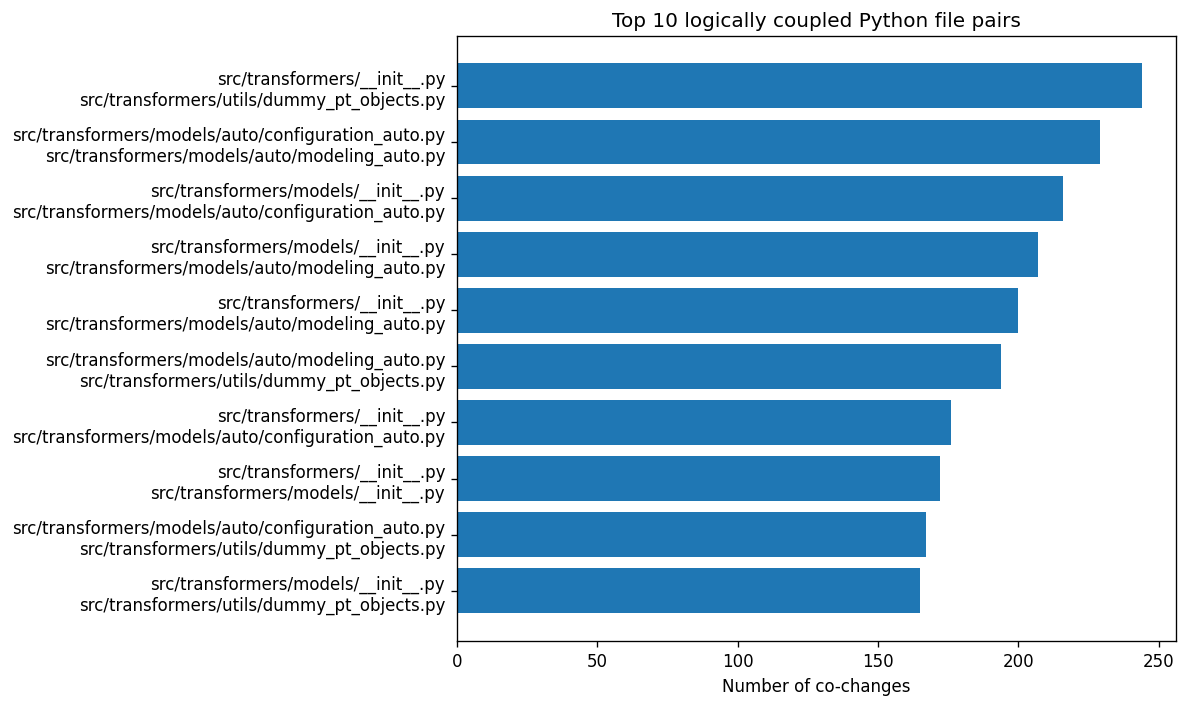

[(('src/transformers/__init__.py',
   'src/transformers/utils/dummy_pt_objects.py'),
  244),
 (('src/transformers/models/auto/configuration_auto.py',
   'src/transformers/models/auto/modeling_auto.py'),
  229),
 (('src/transformers/models/__init__.py',
   'src/transformers/models/auto/configuration_auto.py'),
  216),
 (('src/transformers/models/__init__.py',
   'src/transformers/models/auto/modeling_auto.py'),
  207),
 (('src/transformers/__init__.py',
   'src/transformers/models/auto/modeling_auto.py'),
  200),
 (('src/transformers/models/auto/modeling_auto.py',
   'src/transformers/utils/dummy_pt_objects.py'),
  194),
 (('src/transformers/__init__.py',
   'src/transformers/models/auto/configuration_auto.py'),
  176),
 (('src/transformers/__init__.py', 'src/transformers/models/__init__.py'),
  172),
 (('src/transformers/models/auto/configuration_auto.py',
   'src/transformers/utils/dummy_pt_objects.py'),
  167),
 (('src/transformers/models/__init__.py',
   'src/transformers/utils/dumm

In [16]:
def plot_top_coupled_pairs(coupling_counts, top_n=10, title="Top coupled file pairs"):

    
    top_pairs = sorted(coupling_counts.items(), key=lambda item: item[1], reverse=True)[:top_n] # we sort pairs by co-change count in descending order 

    pair_labels = [f"{a}\n{b}" for (a, b), _ in top_pairs]
    cochange_values = [count for _, count in top_pairs]

    plt.figure(figsize=(10, 6), dpi=120)
    plt.barh(range(len(top_pairs)), cochange_values)
    plt.yticks(range(len(top_pairs)), pair_labels)
    plt.xlabel("Number of co-changes")
    plt.title(title)
    plt.gca().invert_yaxis() 
    plt.tight_layout()
    plt.show()

    return top_pairs 

# we run the analysis for all Python file pairs
all_coupling = compute_logical_coupling(commits)
top10_all = plot_top_coupled_pairs(all_coupling, top_n=10, title="Top 10 logically coupled Python file pairs")
top10_all

- Computation of Logical Coupling restricted to test - non-test pairs

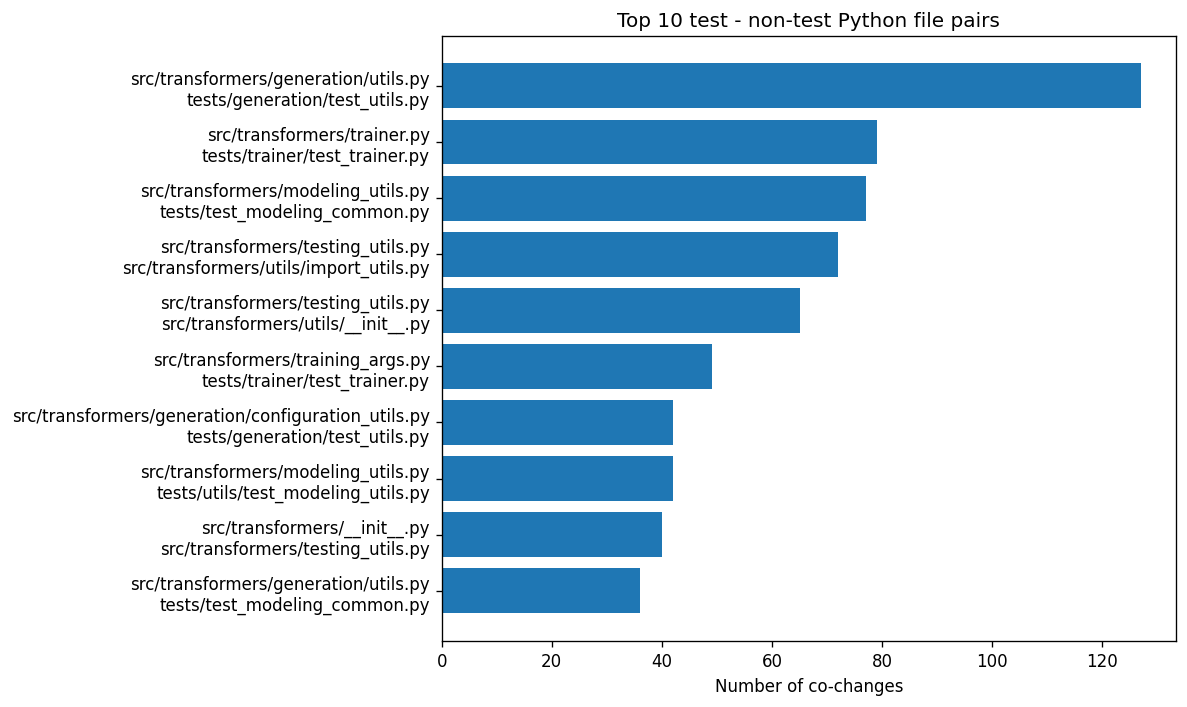

[(('src/transformers/generation/utils.py', 'tests/generation/test_utils.py'),
  127),
 (('src/transformers/trainer.py', 'tests/trainer/test_trainer.py'), 79),
 (('src/transformers/modeling_utils.py', 'tests/test_modeling_common.py'), 77),
 (('src/transformers/testing_utils.py',
   'src/transformers/utils/import_utils.py'),
  72),
 (('src/transformers/testing_utils.py', 'src/transformers/utils/__init__.py'),
  65),
 (('src/transformers/training_args.py', 'tests/trainer/test_trainer.py'), 49),
 (('src/transformers/generation/configuration_utils.py',
   'tests/generation/test_utils.py'),
  42),
 (('src/transformers/modeling_utils.py', 'tests/utils/test_modeling_utils.py'),
  42),
 (('src/transformers/__init__.py', 'src/transformers/testing_utils.py'), 40),
 (('src/transformers/generation/utils.py', 'tests/test_modeling_common.py'),
  36)]

In [17]:
def is_test_file(path):
    return is_python_file(path) and os.path.basename(path).startswith("test") # we consider a python test file those files that start with "test" and end with .py

def filter_test_non_test_pairs(coupling_counts):
    filtered = {}

    for (file_a, file_b), count in coupling_counts.items():
        a_is_test = is_test_file(file_a)
        b_is_test = is_test_file(file_b)

        # we keep pairs where one is test and the other is non-test
        if a_is_test ^ b_is_test:  # XOR-> exactly one True
            filtered[(file_a, file_b)] = count

    return filtered


test_non_test_coupling = filter_test_non_test_pairs(all_coupling)

top10_test_non_test = plot_top_coupled_pairs(
    test_non_test_coupling,
    top_n=10,
    title="Top 10 test - non-test Python file pairs"
)

top10_test_non_test